<a href="https://colab.research.google.com/github/bundickm/DS-Unit-2-Sprint-2-Regression/blob/master/module3-regression-diagnostics/Model_Diagnostics_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression Diagnostics

The purpose of this assigment is introduce you to a new library for linear regression called statmodels which is much better suited for inferential modeling than sklearn. This assignment is also to familiarize yourself with some of most important procedures for improving the interpretability of regression coefficients. You will also perform important statistical tests that will help establish that whether or not important assumptions that safeguard the interpretability of OLS coefficients have been met. 

We will continue to use the Ames Housing Dataset so that you can focus on the techniques and not on cleaning/getting associated with a brand new dataset.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

In [88]:
pd.set_option('max_columns', 100)
df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv')

df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].mean())
df = df.dropna(subset=['GarageYrBlt','MasVnrArea'])
cat_vals = {'Gd':4, 'TA':2, 'Ex':5, 'Fa':3, np.NaN:0,'Po':1}
df['BsmtQual'] = df['BsmtQual'].replace(cat_vals)
df['ExterQual'] = df['ExterQual'].replace(cat_vals)
df['PoolQC'] = df['PoolQC'].replace(cat_vals)
df['HeatingQC'] = df['HeatingQC'].replace(cat_vals)
df['KitchenQual'] = df['KitchenQual'].replace(cat_vals)
df['FireplaceQu'] = df['FireplaceQu'].replace(cat_vals)
df['GarageQual'] = df['GarageQual'].replace(cat_vals)
df['ExterCond'] = df['ExterCond'].replace(cat_vals)
df['BsmtCond'] = df['BsmtCond'].replace(cat_vals)
df['GarageCond'] = df['GarageCond'].replace(cat_vals)
df['GarageFinish'] = df['GarageFinish'].replace({'Fin':2,'RFn':1,np.NaN:0,'Unf':-1})
df['PavedDrive'] = df['PavedDrive'].replace({'Y':1,'P':0,'N':-1})
df['LandSlope'] = df['LandSlope'].replace({'Gtl':3,'Mod':2,'Sev':1})
df['CentralAir'] = df['CentralAir'].replace({'Y':1,'N':0})
df['Electrical'] = df['Electrical'].replace({'SBrkr':3,'FuseA':2,'FuseF':1,'FuseP':0,'Mix':2.5,np.NaN:2.5})
df['Foundation'] = df['Foundation'].replace({'Slab':5,'PConc':4,'CBlock':3,'Stone':2,'BrkTil':1,'Wood':0})
df['Street'] = df['Street'].replace({'Grvl':0,'Pave':1})
df['LandContour'] = df['LandContour'].replace({'Lvl':3,'Bnk':2,'HLS':1,'Low':0})
df['LotShape'] = df['LotShape'].replace({'Reg':3,'IR1':2,'IR2':1,'IR3':0})
df['ln_SalePrice'] = np.log(df['SalePrice'])
df = df[df.describe().columns]

df.head(1)

,Id,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandContour,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,Foundation,BsmtCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,ln_SalePrice
0,1,60,65.0,8450,1,3,3,3,7,5,2003,2003,196.0,4,2,706,0,150,856,5,1,3.0,856,854,0,1710,1,0,2,1,3,1,8,0,0,2003.0,1,2,548,2,2,1,0,61,0,0,0,0,0,2,2008,208500,12.247694


## 1.1 Choose an X and Y variable from your dataset and use them to create a Seaborn Regplot

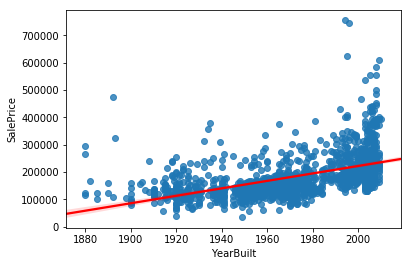

In [89]:
sns.regplot(df['YearBuilt'],df['SalePrice'],line_kws={'color':'r'})

## 1.2 Now using the X variables that you feel like will be the best predictors of y use statsmodel to run the multiple regression between these variables and Y. You don't need to use every X variable in your dataset, in fact it's probably better if you don't. Just pick ones that you have already cleaned that seem the most relevant to house prices.

In [90]:
X = df[['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 
     'GrLivArea', 'TotRmsAbvGrd', 'YrSold', 'FullBath']]
y = df['SalePrice']

model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     512.6
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        20:18:50   Log-Likelihood:                -16452.
No. Observations:                1371   AIC:                         3.292e+04
Df Residuals:                    1362   BIC:                         3.297e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -1.11e+06   1.61e+06     -0.687   

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## 1.3 Identify the standard errors and P-Values of these coefficients in the output table. What is the interpretation of the P-values here?

In [0]:
#TotRmsAbvGrd and YrSold are being considered not statistically significant
#Both also have a counterintuitive coefficient

## 1.4 Remove outliers from your dataset and run the regression again. Do you see a change in some coefficients? Which seem to move the most?

In [92]:
print(df.shape)
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
print(df.shape)

(1371, 53)
(759, 53)


In [93]:
X = df[['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 
     'GrLivArea', 'TotRmsAbvGrd', 'YrSold', 'FullBath']]
y = df['SalePrice']

model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     376.7
Date:                Wed, 01 May 2019   Prob (F-statistic):          9.46e-257
Time:                        20:18:54   Log-Likelihood:                -8806.3
No. Observations:                 759   AIC:                         1.763e+04
Df Residuals:                     750   BIC:                         1.767e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.459e+06   1.44e+06     -1.015   

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [0]:
#TotRmsAbvGrd and YrSold coefficients moved the most

## 1.5 Create a new log(y) variable and use it to run a log-linear regression of your variables using statmodels 

In [94]:
X = df[['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 
     'GrLivArea', 'TotRmsAbvGrd', 'YrSold', 'FullBath']]
y = np.log(df['SalePrice'])

model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     469.5
Date:                Wed, 01 May 2019   Prob (F-statistic):          4.83e-286
Time:                        20:19:20   Log-Likelihood:                 477.73
No. Observations:                 759   AIC:                            -937.5
Df Residuals:                     750   BIC:                            -895.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.1520      7.005      0.735   

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## 2.1 Run a test for high levels of collinearity in your dataset. Calculate the Variance Inflation Factor for each X variable. Do you see VIF values greater than ten? If so try omitting those X variables and run your regression again. Do the standard errors change? Do the coefficients change? Do the coefficients seem to have an interpretation that matches your intuition?

In [95]:
#no features have a high VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = sm.add_constant(X)
vif = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
pd.Series(vif, X.columns)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


const           2.213485e+06
LotArea         1.206238e+00
OverallQual     2.526028e+00
OverallCond     1.361365e+00
YearBuilt       2.530819e+00
GrLivArea       4.319368e+00
TotRmsAbvGrd    3.109857e+00
YrSold          1.010423e+00
FullBath        2.618719e+00
dtype: float64

## 2.2 Variables that have high levels of multicollinearity should also be highly correlated with each other. Calculate your X matrix's correlation matrix to check if the variables highlighted by the VIF test truly are highly correlated.

In [96]:
X.corr()

,const,LotArea,OverallQual,OverallCond,YearBuilt,GrLivArea,TotRmsAbvGrd,YrSold,FullBath
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotArea,NaN,1.000000,0.139857,0.022928,0.014403,0.358264,0.383824,0.013798,0.154142
OverallQual,NaN,0.139857,1.000000,-0.294583,0.651038,0.606905,0.468749,0.001985,0.644883
OverallCond,NaN,0.022928,-0.294583,1.000000,-0.494596,-0.221827,-0.144314,0.091585,-0.352221
YearBuilt,NaN,0.014403,0.651038,-0.494596,1.000000,0.335952,0.242484,-0.029537,0.624429
GrLivArea,NaN,0.358264,0.606905,-0.221827,0.335952,1.000000,0.816933,-0.022583,0.652969
TotRmsAbvGrd,NaN,0.383824,0.468749,-0.144314,0.242484,0.816933,1.000000,-0.020296,0.526709
YrSold,NaN,0.013798,0.001985,0.091585,-0.029537,-0.022583,-0.020296,1.000000,-0.022346
FullBath,NaN,0.154142,0.644883,-0.352221,0.624429,0.652969,0.526709,-0.022346,1.000000


## 2.3 If you have variables with high Variance Inflation Factors, try excluding them from your regression. Do your standard errors improve? (get smaller). If high levels of multicollinearity are removed, the precision of the dataset should increase.

In [0]:
#no features with high VIF

## 2.4 Recalculate your regression using Robust Standard Errors? What happens to your standard errors?

In [98]:
X = df[['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 
     'GrLivArea', 'TotRmsAbvGrd', 'YrSold', 'FullBath']]
y = np.log(df['SalePrice'])

model = sm.OLS(y, sm.add_constant(X))
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     426.2
Date:                Wed, 01 May 2019   Prob (F-statistic):          5.13e-273
Time:                        20:20:03   Log-Likelihood:                 477.73
No. Observations:                 759   AIC:                            -937.5
Df Residuals:                     750   BIC:                            -895.8
Df Model:                           8                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.1520      7.118      0.724   

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [0]:
#Standard error went down significantly

## 2.5 Use scatterplots or Seaborn's pairplot functionality to perform an eyeball test for potential variables that would be candidates for generating polynomial regressors. 

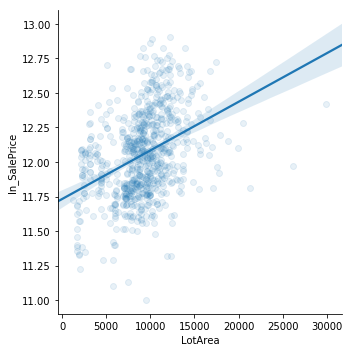

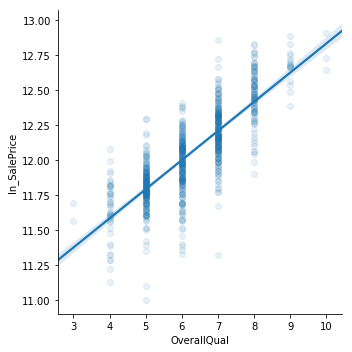

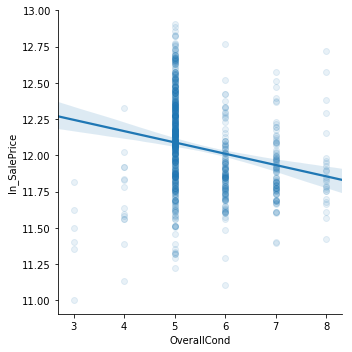

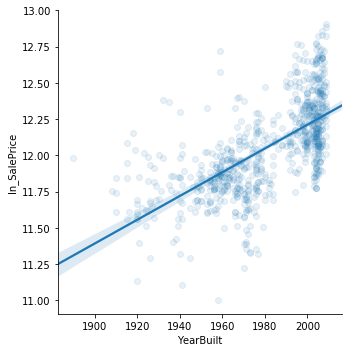

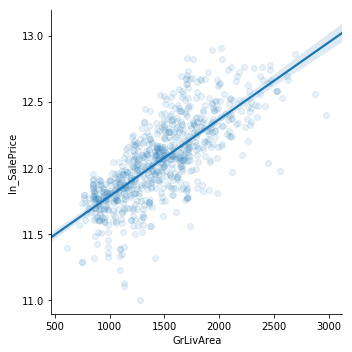

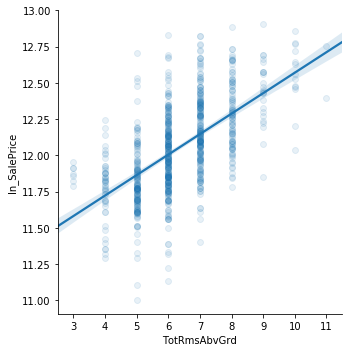

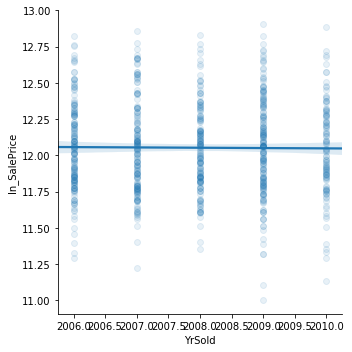

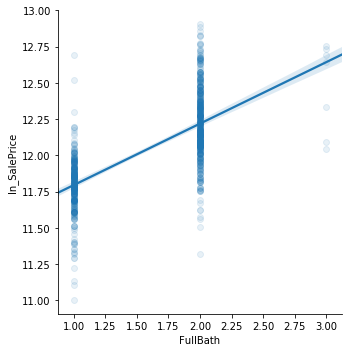

In [99]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 
            'GrLivArea', 'TotRmsAbvGrd', 'YrSold', 'FullBath']
target = 'ln_SalePrice'

features = df[features]
for feature in features:
    sns.lmplot(x=feature, y=target, data=df, scatter_kws=dict(alpha=0.1))
    plt.show()

## 2.6 Use seaborn's residplot to plot the distribution of each x variable's residuals. Does these plots indicate any other features that would be potential candidates for polynomial features.

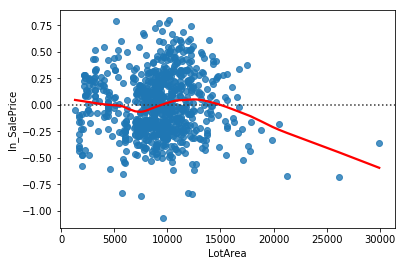

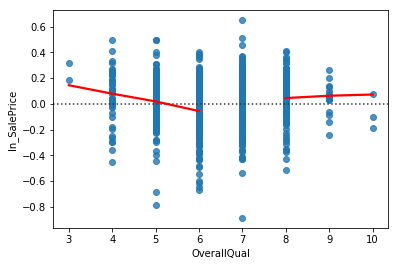

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


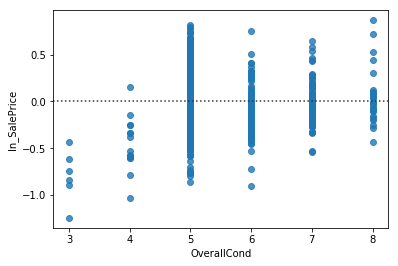

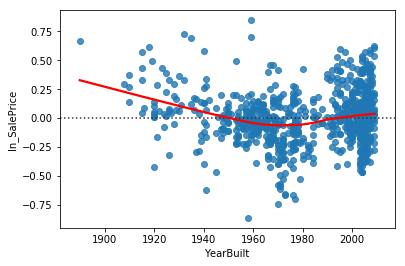

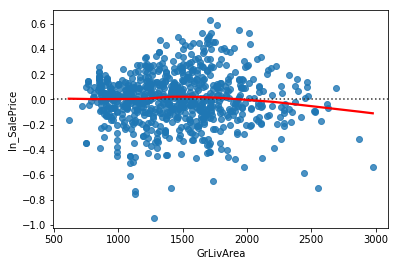

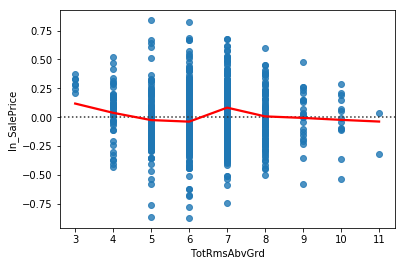

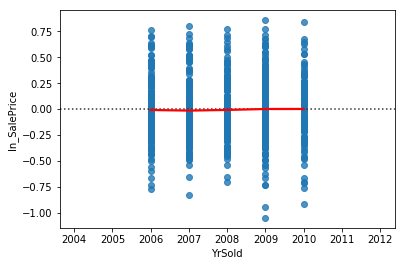

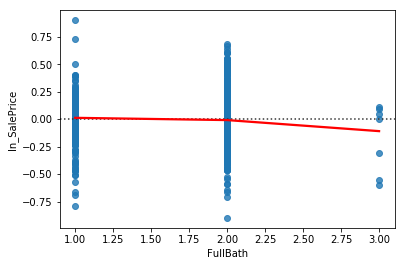

In [100]:
#candidates are LotArea,YearBuilt, and GrLivArea
features = ['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 
            'GrLivArea', 'TotRmsAbvGrd', 'YrSold', 'FullBath']
target = 'ln_SalePrice'

for feature in features:
    sns.residplot(X[feature], y=df[target], lowess=True, line_kws=dict(color='r'))
    plt.show()

## 2.6 Feature Engineer the appropriate polynomial features from your analysis above and include them in one final log-polynomial, robust standard error, regression. Do the coefficients of this most advanced regression match your intuition better than the coefficients of the very first regression that we ran with the Statmodels library?

In [0]:
df['LotArea^2'] = df['LotArea']**2
df['YearBuilt^2'] = df['YearBuilt']**2
df['GrLivArea^2'] = df['GrLivArea']**2

In [102]:
X = df[['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 
        'GrLivArea', 'TotRmsAbvGrd', 'YrSold', 'LotArea^2',
        'YearBuilt^2', 'GrLivArea^2']]
y = df[target]

model = sm.OLS(y, sm.add_constant(X))
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           ln_SalePrice   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     374.6
Date:                Wed, 01 May 2019   Prob (F-statistic):          3.46e-270
Time:                        20:21:28   Log-Likelihood:                 503.76
No. Observations:                 759   AIC:                            -985.5
Df Residuals:                     748   BIC:                            -934.6
Df Model:                          10                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          113.9510     42.973      2.652   

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 9
  'rank is %d' % (J, J_), ValueWarning)


# Stretch Goals

- Research the assumptions that are required for OLS to be BLUE the "Best Linear Unbiased Estimator". You might try searching and trying to understand the conditions of what's called the Gauss-Markov Theorem.
- Research other diagnostic tests. Can you show that residuals are normally distributed graphically?
- Write a blog post about inferential modeling using linear regression.